In [1]:
import pandas as pd
import raphtory as rp
import datetime as dt
import networkx as nx

import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

from plotting_utils import *

# Reading in a graph of interactions on Stack Exchange

In [2]:
file = "/Users/naomiarnold/CODE/Raphtory/raphtory-research/stackexchange/sx-mathoverflow.txt"
sx_df = pd.read_csv(file, names = ["src", "dst", "time"],sep=" ")
display(sx_df)

,src,dst,time
0,1,4,1254192988
1,3,4,1254194656
2,1,2,1254202612
3,25,1,1254232804
4,14,16,1254263166
...,...,...,...
506545,21349,88580,1457260401
506546,20031,1114,1457261526
506547,51428,1114,1457261724
506548,56259,56259,1457261848


In [3]:
def load_pandas(data:pd.DataFrame):
    g = rp.Graph()
    for (_, src_id, dst_id, time) in data.itertuples():
        g.add_vertex(timestamp = time, id = src_id)
        g.add_vertex(timestamp = time, id = dst_id)

        # Remove self loops
        if src_id != dst_id:
            g.add_edge(timestamp = time, src = src_id, dst = dst_id)
    return g

In [5]:
g = load_pandas(sx_df)

In [ ]:
g.add_edge

In [6]:
g = nx.Graph()

In [ ]:
g.add_edge

# Working with the aggregate graph object

Take metrics you might expect in something like networkx applied to the full aggregate graph. Get degree of all nodes for example

In [5]:
degrees = sorted([(v.id(), v.in_degree()) for v in g.vertices()], key = lambda x: x[1], reverse=True)
print(degrees[:10])

[(11142, 968), (6094, 914), (290, 910), (297, 724), (1946, 721), (2841, 551), (18060, 539), (1459, 536), (1409, 506), (1149, 477)]


# Handy functionality for tracking vertex properties over time in different window sizes
Get the top 5 all time leaders by degree and track their connectivity over time

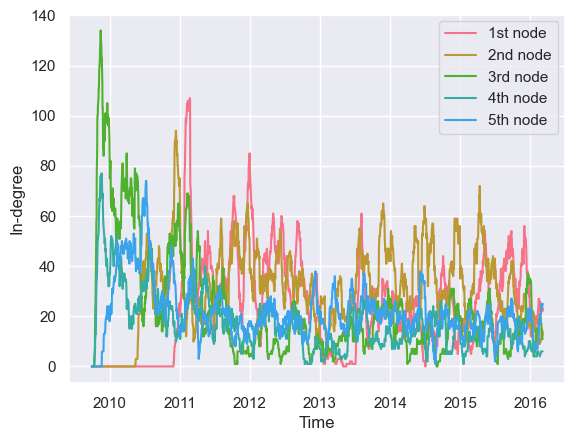

In [6]:
sns.set()
sns.set_palette("husl")

window_size = 2592000

n = 5
leaders = [x[0] for x in degrees[:n]]
timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in g.rolling(window = window_size,step=86400)]

fig, ax = plt.subplots()

for i,vid in enumerate(leaders):
    deg = list(map( lambda v: v.in_degree(), g.vertex(vid).rolling(window = window_size,step=86400)))
    ax.plot(timestamps,deg,label= get_ordinal_number(i+1) + " node")

ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("In-degree")
plt.savefig("degree-trajectories-top5.png")
plt.show()

# Whole graph metrics and different window sizes, including the growing aggregate graph

In [7]:
window_sizes = [86400,604800,2592000,31536000]
window_names = ["1 day", "1 week", "1 month", "1 year"]

# Aggregate graph properties
views = g.expanding(step = 86400)
timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in views]

aggr_vertices = [v.count_vertices() for v in views]

agg_window = np.zeros(len(timestamps),dtype=int)
df = pd.DataFrame({"time": timestamps, "window":agg_window, "vertices": aggr_vertices})

# Same properties for different window sizes
for i in range(3):
    views = g.rolling(window=window_sizes[i], step=86400)
    diff_size = int(window_sizes[i]/86400)

    timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in views]
    vertices = [v.count_vertices() for v in views]

    to_join = pd.DataFrame({"time": timestamps, "window":[window_sizes[i] for k in range(len(timestamps))], "vertices": vertices})
    df = pd.concat([df,to_join],copy=False)

for w in window_sizes:
    diff_size = int(w / 86400)
    df.loc[df['window'] == w, 'new_vertices'] = pd.Series(df.loc[df['window'] == 0, 'vertices'].diff(diff_size), index = df.loc[df['window'] == w, 'vertices'].index)
    df.loc[df['window'] == w, 'prop_new'] = np.where(df.loc[df['window'] == w, 'vertices'] < 1, 0, df.loc[df['window'] == w, 'new_vertices'] / df.loc[df['window'] == w, 'vertices'])

# Plotting out the number of active users and the proportion of those that are new

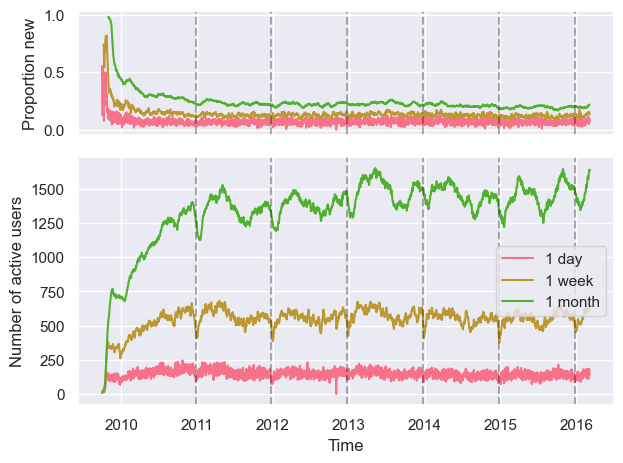

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2, gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

for i in range(3):
    sub_df = df[df['window'] == window_sizes[i]]
    ax1.plot(sub_df['time'], sub_df['prop_new'],label=window_names[i])
    ax2.plot(sub_df['time'],sub_df['vertices'],label=window_names[i])

for i in range(6):
    ax1.axvline(dt.datetime(2010+i,12,25),color="black",linestyle="--", alpha=0.3)
    ax2.axvline(dt.datetime(2010+i,12,25),color="black",linestyle="--", alpha=0.3)

ax2.set_xlabel("Time")
ax1.set_ylabel("Proportion new")
ax2.set_ylabel("Number of active users")

ax2.legend()
plt.tight_layout()
plt.savefig("new-existing-users.png")

# Null model comparisons
Number of users according to real and timestamp-shuffled data

In [9]:
from raphtory.nullmodels import *
from raphtory.algorithms import weakly_connected_components
from collections import Counter

experiments = 5

for i in range(3):
    w = window_sizes[i]
    results_vertices = np.zeros((experiments,len(df[df['window']==w])))
    for ex in range(experiments):
        sx_shuffled = shuffle_column(sx_df,col_number=2)
        g_shuff = load_pandas(sx_shuffled)
        views = g_shuff.rolling(window=window_sizes[i],step=86400)
        results_vertices[ex,:] = np.array([v.count_vertices() for v in views])
    df.loc[df['window'] == w, 'vert_shuffled_mean'] = results_vertices.mean(axis=0)
    df.loc[df['window'] == w, 'vert_shuffled_sd'] = results_vertices.std(axis=0)

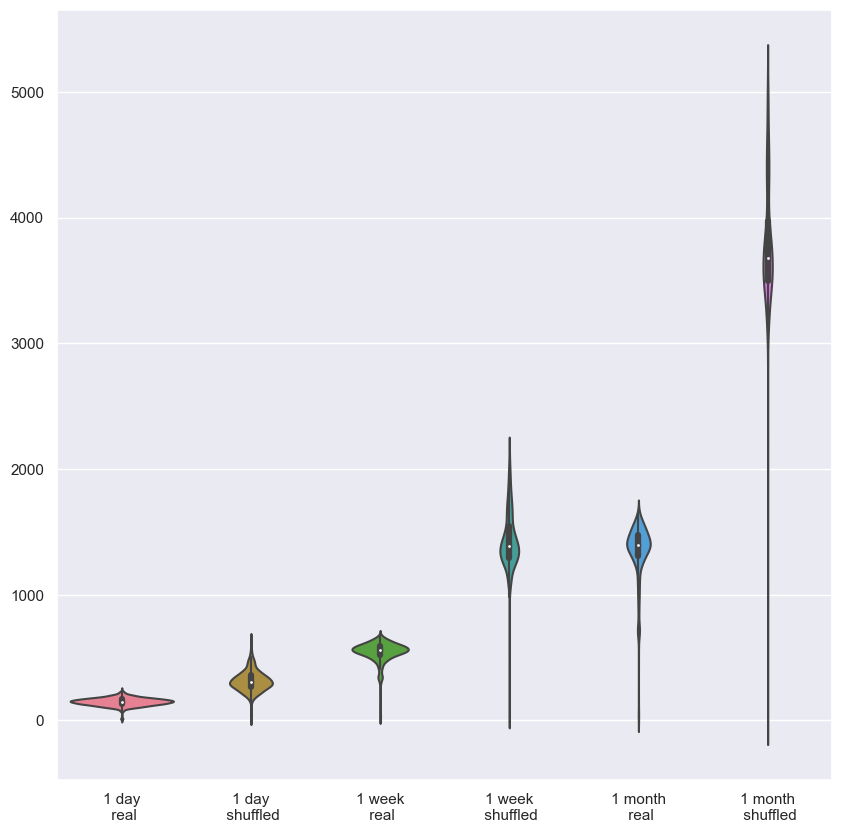

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 10))
to_plot = []
labels = []
for i in range(3):
    real = list(df[df['window']==window_sizes[i]]['vertices'])
    shuffled = list(df[df['window']==window_sizes[i]]['vert_shuffled_mean'])
    to_plot.append(real)
    to_plot.append(shuffled)
    labels.append(window_names[i]+ "\n real")
    labels.append(window_names[i]+ "\n shuffled")

sns.violinplot(data=to_plot)
ax.set_xticklabels(labels)
plt.show()

# Hourly number of users

In [31]:
views = g.rolling(window=3600, step=3600)
hour_vertices = [v.count_vertices() for v in views]

In [32]:
timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in views]
to_join = pd.DataFrame({"time": timestamps, "window":[3600 for k in range(len(timestamps))], "vertices": hour_vertices})
df = pd.concat([df,to_join],copy=False)

In [33]:
df['week_days'] = df["time"].apply(lambda x: x.weekday())
df['hour'] = df["time"].apply(lambda x: x.hour)

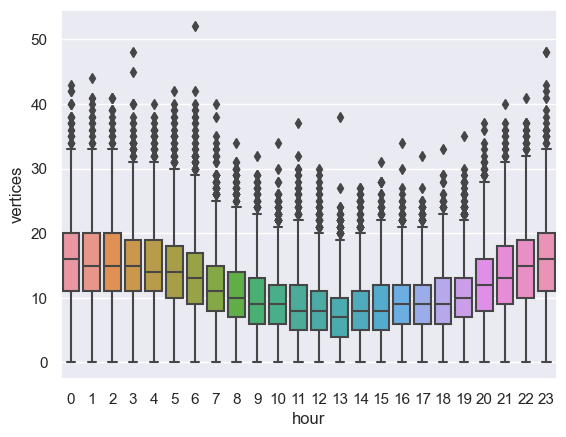

In [34]:
ax = sns.boxplot(data=df[df['window']==3600], x='hour', y='vertices')

# Temporal motifs

In [16]:
from raphtory.algorithms import all_local_motifs
counts = all_local_motifs(g,3600)

In [17]:
df = pd.DataFrame(counts).transpose()

In [18]:
# display(df)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
20833,3,0,0,0,2,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
34239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1826,49,0,5,1,0,0,0,1,58,0,...,0,12,4,4,4,0,0,3,7,1
88163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
motifs = np.array(df.sum(axis=0))
motifs[32:] = motifs[32:]/3
motifs_3d = to_3d_heatmap(motifs)
print(motifs_3d)

[[17595  3826  2553   501  6088 22084]
 [ 2012  1621   898   197  3543   996]
 [ 2045  2676  2044  5964  2635  2027]
 [ 4395  1615  8820  1687  1109   651]
 [  836  4088  1477  3219  2323  4780]
 [16637  1930  9213  5081  3317 21493]]


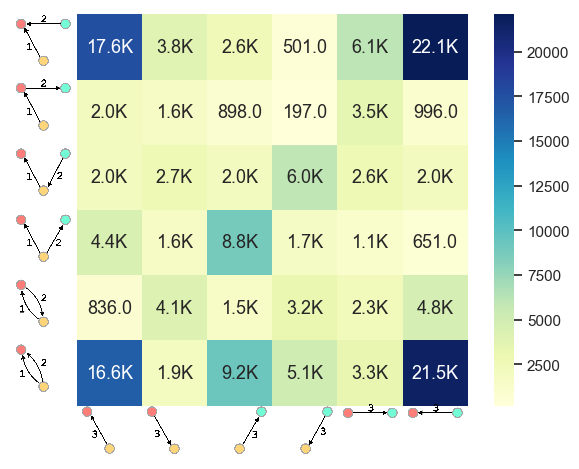

In [21]:
fig, ax = plt.subplots()

labels = get_labels(motifs_3d)
ax = sns.heatmap(motifs_3d,square=True,  cmap="YlGnBu", cbar=True, annot=labels,annot_kws={"size":13}, fmt='', cbar_kws={"shrink": 1.0})

for i in range(6):
    offset_image("x",i,i,ax)
    offset_image("y",i,i,ax)

ax.tick_params(axis='x', which='major', pad=50)
ax.tick_params(axis='y', which='major', pad=50)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.savefig("sx-motifs-all.png")